In [77]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.ticker
import FilterShapes as filters
import audio_dspy as adsp
import sounddevice as sd
from scipy.io.wavfile import read
import soundfile as sf
from IPython.display import Audio

In [138]:
def chirpLog (f0, f1, duration, fs):
    N = int (duration * fs)
    n = np.arange (N)
    
    beta = N / np.log(f1 / f0)
    phase = 2 * np.pi * beta * f0 * (pow(f1 / f0, n / N) - 1.0)
    phi = np.pi / 180
       
    return np.cos ((phase + phi)/fs)

def chrp2ir (ss, rs):
    N = max (len (rs), len (ss))
    SS = np.fft.fft (ss, n=N)
    RS = np.fft.fft (rs, n=N)
    
    H = RS/SS
    h = np.real (np.fft.ifft (H))
    return h

class Biquad:
    def __init__ (self):
        self.z = np.zeros (3)
        self.b = np.array ([1, 0, 0])
        self.a = np.array ([1, 0, 0])
        self.saturator = lambda x : x
    
    def setCoefs (self, b, a):
        assert (np.size (b) == np.size (self.b))
        assert (np.size (a) == np.size (self.a))
        self.b = np.copy (b)
        self.a = np.copy (a)

    # Direct-Form II, transposed
    def processSample (self, x):
        y = self.z[1] + self.b[0]*x
        self.z[1] = self.saturator (self.z[2] + self.b[1]*x - self.a[1]*y)
        self.z[2] = self.saturator (self.b[2]*x - self.a[2]*y)
        return y

    def processBlock (self, block):
        for n in range (len (block)):
            block[n] = self.processSample (block[n])
        return block

In [143]:
data, fs = sf.read('drums.wav')
x = data[:,0] # stereo to mono
Audio(data = x, rate = fs)

In [149]:
#x = 0.1 * x
b, a = filters.calcCoefsLowShelf(5000, 0.707, 20, fs)
nlBQ = Biquad()
nlBQ.setCoefs(b, a)
#nlBQ.saturator = lambda x : x
nlBQ.saturator = lambda x : np.tanh(np.copy(x))
#nlBQ.saturator = lambda x : min(1.0, max(-1.0, x)) # hardClip
#nlBQ.saturator = lambda x : (2.0 / 3.0) if x > 1.0 else ((-2.0 / 3.0) if x < -1.0 else (x - x*x*x/3.0)) # softClip

y = nlBQ.processBlock (np.copy(x))
Audio(data = y, rate = fs)

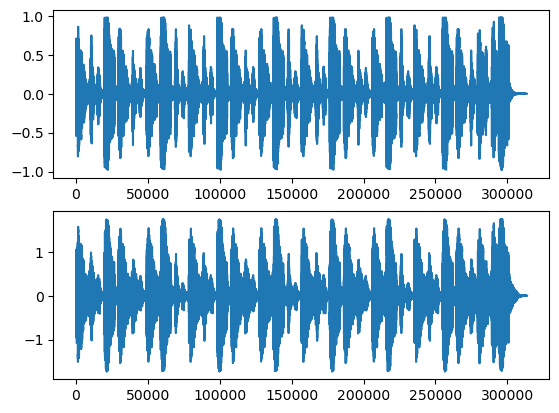

In [145]:
plt.subplot(2, 1, 1)
plt.plot(x)
plt.subplot(2, 1, 2)
plt.plot(y)

(0.0, 20000.0)

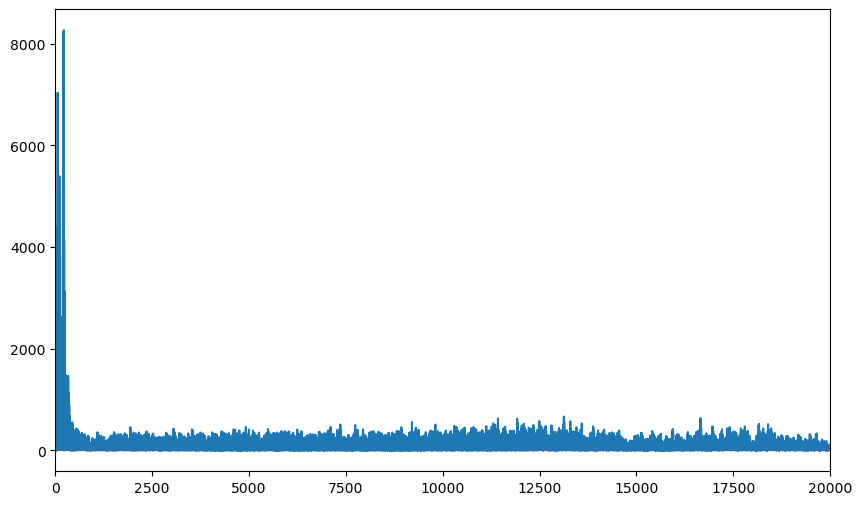

In [146]:
fft_result = np.fft.fft(x)
frequencies = np.fft.fftfreq(len(fft_result), 1/fs)  # Frequency axis

# Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_result))
plt.xlim((0, 20000))